# Evaluation des Neuronalen Netzes zur Giraffenpuzzle-Erkennung
Das Notebook [Giraffenpuzzle-Training](https://www.kaggle.com/code/toedtlifhsg/giraffenpuzzle-training?scriptVersionId=187781292) produzierte als Ausgabe ein fertig trainiertes neuronales Netz, sowie eine Aufsplittung des Giraffenpuzzleteile-Datensatzes in einen Trainings- und einen Testdatensatz. Hier wollen wir das Modell laden und auf dem Testdatensatz evaluieren.

In [61]:
import matplotlib.pyplot as plt #Plottingroutinen zur Visualisierung
import numpy as np # Arrays- "The fundamental package for scientific computing with Python" 
import pandas as pd #Umgang mit Tabellen- hier nur zum Laden der Klassenlabels
import tensorflow as tf #Tensorflow, trainieren von neuronale Netzen (inkl. Keras)
import shutil # Dateisystemmanipulationen, insbesondere für das Kopieren von Dateien
from pathlib import Path #Pathlib, Umgang mit Dateipfaden
import scikitplot # Visualisierungen von Klassifikationsperformanz

In [62]:
# Modell laden:
loaded_model = tf.keras.models.load_model('../04_Training/Model/model_Gipfeli_testing.keras')
# Excel-Datei mit Angabe, ob ein Bild ein Test- oder ein Trainingsbild ist:
train_or_test = pd.read_excel('../04_Training/train_test_split.xlsx')
train_or_test.columns = ['Dateiname','TrainOrTest']

# .DS_Store und versteckte Dateien entfernen
train_or_test = train_or_test[~train_or_test['Dateiname'].str.contains('DS_Store', na=False)]
train_or_test = train_or_test[~train_or_test['Dateiname'].str.startswith('.', na=False)]

Hiermit haben wir die Zuordnung unserer Daten zu den Trainings- und Testdaten. Wir wollen hier nur noch Bilder, mit welchen das Modell nicht trainiert wurde.

In [63]:
train_or_test

,Dateiname,TrainOrTest
0,Laugengipfel_low_light_34.jpg,train
1,Laugengipfel_low_light_20.jpg,train
2,Keimkraft_Gipfel_light_15.jpg,train
3,Laugengipfel_light_19.jpg,train
4,Keimkraft_Gipfel_light_01.jpg,train
...,...,...
169,Keimkraft_Gipfel_light_30.jpg,test
170,Keimkraft_Gipfel_low_light_41.jpg,test
171,Keimkraft_Gipfel_light_18.jpg,test
172,Laugengipfel_light_14.jpg,test


Wir erstellen nun zwei Baumstrukturen (für Trainings- und Testdaten). Das Klassenlabel extrahieren wir aus dem Dateinamen- hier ist es alles vor dem ersten Underscore, "_".

In [64]:
# Extrahiere Klassenlabel aus Dateiname
Klassenlabel = train_or_test['Dateiname'].map(lambda s: s[:s.find('_')] if not s.startswith('.') else None)
train_or_test = train_or_test[Klassenlabel.notna()]
Klassenlabel = Klassenlabel[Klassenlabel.notna()]
train_or_test['Klasse'] = Klassenlabel

testbilder = train_or_test[train_or_test['TrainOrTest'] == 'test']
testbilder = testbilder[~testbilder['Klasse'].str.startswith('.', na=False)]
y_test = Klassenlabel.loc[testbilder.index]

# Kopiere die Testbilder in eine Baumstruktur
for irow,row in testbilder.iterrows():
    Dateiname,TrainOrTest,Klasse = (row.Dateiname,row.TrainOrTest,row.Klasse)

    # jede Datei mit ".DS_Store" im Namen überspringen
    if "DS_Store" in Dateiname:
        continue

    fullfilename = Path('../02_Alle_Gipfel')/Dateiname
    Baumstrukturpfad = Path('./')/'test'
    (Baumstrukturpfad/Klasse).mkdir(exist_ok=True,parents=True)
    shutil.copyfile(fullfilename,Baumstrukturpfad/Klasse/Dateiname)

tf.Dataset ist eine Tensorflowklasse, welche effizient Trainingsbilder aus der Baumstruktur lädt.

In [65]:
image_size=(128,128)
batch_size=8
test_ds = tf.keras.utils.image_dataset_from_directory(
    Baumstrukturpfad,  #es ist wichtig, dass zur Validierung keine Testdaten verwendet werden!
    validation_split=0.0,
    #subset="validation",
    shuffle=False, # Das ist wichtig, da wir später die Bilder in der gleichen Reihenfolge aus dem Dataset extrahieren müssen, in der wir sie dem Modell zur prediction gefüttert haben.
    seed=123,
    image_size=image_size,
    batch_size=batch_size)

Found 53 files belonging to 3 classes.


Steht da in der letzten Zeile `Found 94 files belonging to 20 classes.`, o.ä.? Gut!
Laden wir diese Bilder nun als Numpy-Arrays. Es gibt andere Möglichkeiten, das gleiche zu erreichen, aber jedenfalls erhalten wir einen Numpy-Array mit den Dimensionen (Anzahl Bilder, 64,64, Anzahl Farbkanäle).

In [66]:
L = [x for x in test_ds] # wir extrahieren die Testbilder aus dem Dataset
#X_test = [x.numpy().shape for x,y in L]
X_test = np.vstack([x.numpy() for x,y in L])
y_test = np.hstack([y.numpy() for x,y in L])
X_test.shape,y_test.shape

((53, 128, 128, 3), (53,))

Wir überprüfen, dass zumindest das erste Bild in Xtest dem ersten eintrag in der testbilder-Liste entspricht:

In [67]:
valid_testbilder = [f for f in sorted(testbilder.Dateiname) if "DS_Store" not in f]
testbildname = valid_testbilder[0]
dfrow = testbilder[testbilder.Dateiname==testbildname]
testbildklasse = dfrow.Klasse.iloc[0]
dfrow

,Dateiname,TrainOrTest,Klasse
112,Buttergipfel_light_04.jpg,test,Buttergipfel


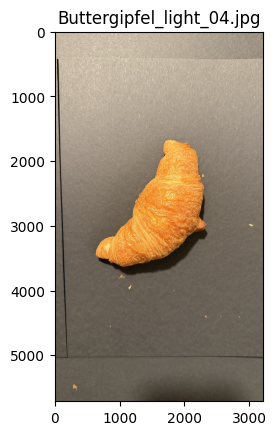

In [68]:
testbild1 = plt.imread(Baumstrukturpfad/testbildklasse/testbildname)
plt.imshow(testbild1)
plt.title(testbildname);

Das entsprechende Bild in `X_test` wurde zentriert, d.h. die Farben stimmen nicht mehr:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


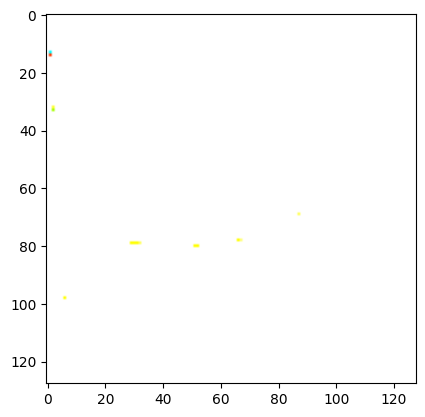

In [69]:
import matplotlib.pyplot as plt
plt.imshow(X_test[0]);

Die obigen zwei Bilder könnten das gleiche Bild sein (jenes unten ist so, wie es das neuronale Netz in etwa sieht...). D.h. wir verstehen nun die Reihenfolge der Predictions: 

In [70]:
yhat_test = loaded_model.predict(X_test)
yhatnum_test = yhat_test.argmax(axis=1)
yhat_test.shape

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x35d61eb90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


(53, 3)

In [71]:
y_test,yhatnum_test

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2]))

Das ist nun also der Klassenindex- da wir die Bilder nicht "geshuffled" haben, ist zumindest die Sequenz `y_test` monoton. Bei `yhatnum_test` (also unseren Vorhersagen auf diesen Bildern) gibt es einige wenige Abweichungen. Das ist zu erwarten. Wenn wir nur wüssten, welcher Klasse das zugehört?!  
Aber weil wir zu neugierig sind, wie gut das Modell sein könnte, rechnen wir ohne dieses Wissen mal die Genauigkeit aus:

In [72]:
Genauigkeit = np.mean(np.where(y_test==yhatnum_test,1,0)) 
# np.where könnte man auch weglassen, so: Genauigkeit = np.mean(y_test==yhatnum_test). 
# Aber was ist der Mittelwert von True, False, True? 
# Klarer ist's wenn wir mit where ersetzen: True->1 und False->0
assert Genauigkeit==np.mean(y_test==yhatnum_test) # Ergibt einen Fehler, sollte das mal nicht mehr stimmen
print(f'Die Testgenauigkeit ist {100*Genauigkeit:3.1f}%.')

Die Testgenauigkeit ist 96.2%.


Nun würden wir also auch gerne die Label kennen. Wir müssen den Labelindex (die Zahl) mit dem Namen der Klasse in Verbindung bringen. Zum Glück werden die Klassenlabel sortiert durchgezählt, so dass dieser Schritt nicht schwer ist:

In [73]:
sorted_class_labels = np.array(sorted(Klassenlabel.unique())) #Labels in Keras der Funktion image_dataset_from_directory werden immer alphanummerisch sortiert den Indices zugeordnet
sorted_class_labels

array(['Buttergipfel', 'Keimkraft', 'Laugengipfel'], dtype='<U12')

In [74]:
yhat_label = pd.Series(sorted_class_labels[yhatnum_test],index=testbilder.index)
y_test_label = pd.Series(sorted_class_labels[y_test],index=testbilder.index)
# das vorhergesagte Label:
yhat_label

108    Buttergipfel
109    Buttergipfel
110    Buttergipfel
111    Buttergipfel
112    Buttergipfel
118    Buttergipfel
119    Buttergipfel
120    Buttergipfel
121    Buttergipfel
122    Buttergipfel
123    Buttergipfel
127       Keimkraft
128    Buttergipfel
129    Buttergipfel
130    Buttergipfel
131       Keimkraft
133       Keimkraft
134       Keimkraft
138       Keimkraft
140       Keimkraft
141       Keimkraft
142       Keimkraft
143       Keimkraft
144       Keimkraft
145       Keimkraft
146       Keimkraft
147       Keimkraft
148       Keimkraft
149       Keimkraft
150       Keimkraft
151       Keimkraft
152       Keimkraft
153       Keimkraft
154       Keimkraft
155       Keimkraft
156    Laugengipfel
157    Laugengipfel
158    Laugengipfel
159    Laugengipfel
160    Laugengipfel
161    Laugengipfel
162    Laugengipfel
163       Keimkraft
164    Laugengipfel
165    Laugengipfel
166    Laugengipfel
167    Laugengipfel
168    Laugengipfel
169    Laugengipfel
170    Laugengipfel


In [75]:
# und das Tatsächliche:
y_test_label

108    Buttergipfel
109    Buttergipfel
110    Buttergipfel
111    Buttergipfel
112    Buttergipfel
118    Buttergipfel
119    Buttergipfel
120    Buttergipfel
121    Buttergipfel
122    Buttergipfel
123    Buttergipfel
127    Buttergipfel
128    Buttergipfel
129    Buttergipfel
130    Buttergipfel
131       Keimkraft
133       Keimkraft
134       Keimkraft
138       Keimkraft
140       Keimkraft
141       Keimkraft
142       Keimkraft
143       Keimkraft
144       Keimkraft
145       Keimkraft
146       Keimkraft
147       Keimkraft
148       Keimkraft
149       Keimkraft
150       Keimkraft
151       Keimkraft
152       Keimkraft
153       Keimkraft
154       Keimkraft
155       Keimkraft
156    Laugengipfel
157    Laugengipfel
158    Laugengipfel
159    Laugengipfel
160    Laugengipfel
161    Laugengipfel
162    Laugengipfel
163    Laugengipfel
164    Laugengipfel
165    Laugengipfel
166    Laugengipfel
167    Laugengipfel
168    Laugengipfel
169    Laugengipfel
170    Laugengipfel


In [76]:
# Natürlich muss die gleiche Genauigkeit rauskommen, wenn wir sie mit den Labels berechnen, anstatt mit den Labelindices:
Genauigkeit2 = (yhat_label==y_test_label).mean()
print(f'Die Testgenauigkeit ist {100*Genauigkeit2:3.1f}%.')

Die Testgenauigkeit ist 96.2%.


Schliesslich können wir uns noch die Wahrscheinlichkeit merken, mit welcher das Neuronale Netz eine Klasse identifiziert hat. Dies ist also die grösste Zahl unter den $P(y=c_i|X)$ für alle Klassen $c_1$,...,$c_C$ ($C$ der Anzahl Klassen unseres Problems, `yhat_test.shape[1]`.

In [77]:
P = np.max(yhat_test,axis=1)
P.shape

(53,)

# Scikit-Plot
Wir sind bereit! Wir kennen die Testbilder, deren zugehörige Klassenlabel und Vorhersagen durch das geladene Modell. Wir folgen der Dokumentation [hier](https://scikit-plot.readthedocs.io/en/stable/metrics.html). Berechnen wir Metriken! Wir beginnen mit der Confusion Matrix:

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

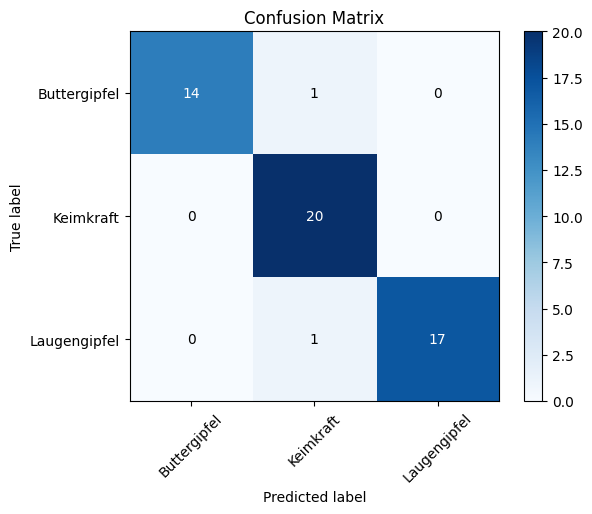

In [78]:
from scikitplot.metrics import plot_confusion_matrix
plot_confusion_matrix(y_test_label,yhat_label,labels=sorted_class_labels,x_tick_rotation=45)

Beachten Sie, wie hübsch blockdiagonal die confusion matrix geworden ist. Dies zeigt, dass das Modell sich meist in der Form, und selten bis nie in der Farbe irrt.  
Ein offensichtliches Problem ist natürlich, dass wir den Grossteil der Daten zum Training benutzt haben (das ist gängige Praxis), und nun nur wenige Beispiele (pro Klasse) übrig haben, um die Präzision und den Recall der Klasse zu schätzen. Mehr Daten wären schon praktisch...

In [79]:
display((y_test_label==yhat_label).value_counts())
print('-'*30)
for curr_class_str in yhat_label.unique():
    curr_class_results=(y_test_label[y_test_label==curr_class_str]==yhat_label[y_test_label==curr_class_str])
    print(f'{curr_class_str:<10}:{100*curr_class_results.mean():3.0f}%')

True     51
False     2
Name: count, dtype: int64

------------------------------
Buttergipfel: 93%
Keimkraft :100%
Laugengipfel: 94%


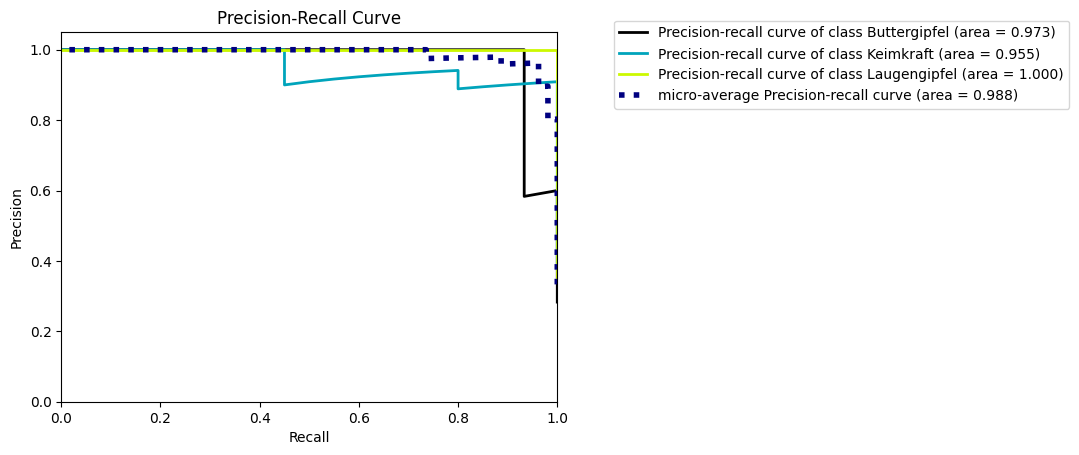

In [80]:
ax = plt.subplot(1,1,1)
scikitplot.metrics.plot_precision_recall(y_test_label,yhat_test,ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05)); #Legende ausserhalb des Plots- sonst sieht man nichts

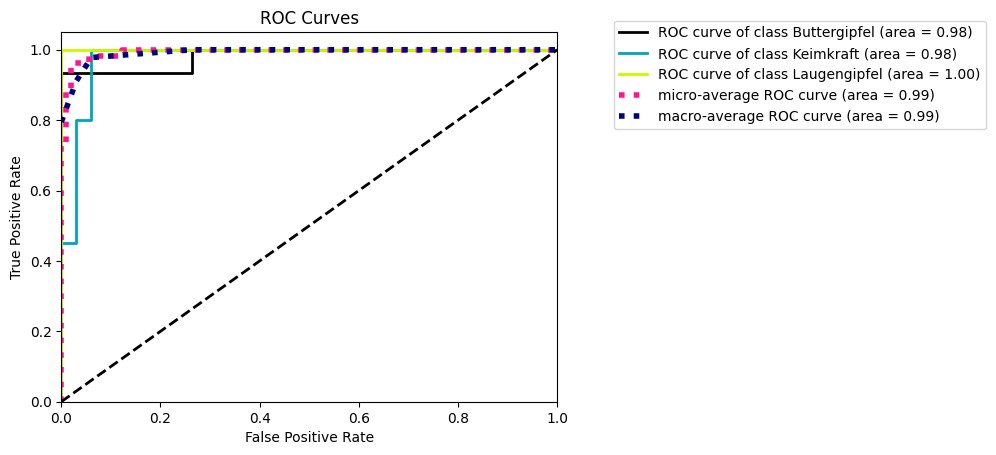

In [81]:
ax = plt.subplot(1,1,1)
scikitplot.metrics.plot_roc(y_test_label,yhat_test,ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05)); #Legende ausserhalb des Plots- sonst sieht man nichts

Ein Problem hier ist, dass das neuronale Netz für recht viele Klassen ("area=1.000") eine extreme Precision-Recall-Kurve ausgibt- von (0,1) über (1,1) nach (1,0). Aber wer würde sich schon darüber beklagen!

Zur Erinnerung, dies ist das Modell, das die obigen Resultate erziehlt hat. Wir können es grundsätzlich irgendwo (auf einem Raspberry-Pi?) laden und dort Vorhersagen generieren.

In [82]:
loaded_model 

<Functional name=Gipfellisucher, built=True>